# Analyse de l'année 2020

## Nettoyage des données et ajout de la colonne Prixm2

In [67]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import seaborn as sns

data = pd.read_csv("valeursfoncieres-2020.txt",sep= '|',decimal= ',')
data['Prixm2'] = data['Valeur fonciere']/data['Surface terrain']
for k,v in data.isnull().sum().items():
    if(v > 1200000):
        del data[k]
def change(x):    #change le format des n° des département ex: 1 => 01          
    y=""          # pour concorder avec le fichier "departements-avec-outre-mer.geojson"
    if str(x).isdigit():
        if int(x)<10:
            y="0{}".format(x)
        else:
            y=str(x)
    else:
        y=str(x)
    return y
data["Code departement"]=data["Code departement"].apply(lambda x: change(x))
data["Valeur fonciere"]=data["Valeur fonciere"].apply(lambda x: float(str(x).replace(",","."))) #valeurs foncieres en float
data['ValParSurf'] = data['Valeur fonciere'].div(data['Surface terrain'])
data.loc[~np.isfinite(data['ValParSurf']), 'ValParSurf'] = np.nan  # change les valeurs "inf" (dû a la division par 0) en NaN

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (14,18,23,24,26,28,41) have mixed types.Specify dtype option on import or set low_memory=False.



## Graphique du nombre de mutations en fonction du temps et du type de local 

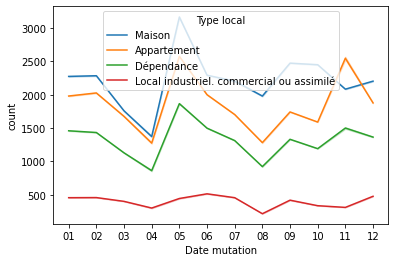

In [68]:
datamois = pd.DataFrame(data,columns=['Date mutation','Type local'])
datamois['Date mutation'] = datamois['Date mutation'].apply(lambda x: x.split(sep='/')[1])
datamois['count'] = datamois.groupby('Date mutation').transform('count')
datamois['count'] = data.groupby(['Type local', 'Date mutation']).transform('count')
sns.lineplot(data=datamois, x="Date mutation", y="count", hue='Type local')

On constate que peu importe le type de local, toutes les mutations suivent les mêmes tendances en fonction du temps.

## Graphique du nombre de mutations en fonction du temps et du type de voie

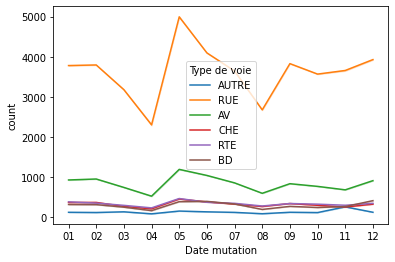

In [69]:
datamois = pd.DataFrame(data,columns=['Date mutation','Type de voie'])
datamois['Type de voie'] = datamois['Type de voie'].apply(lambda x: 'AUTRE' if (x != 'RUE' and x != 'AV' and x != 'RTE' and x != 'CHE' and x != 'BD') else x)
datamois['Date mutation'] = datamois['Date mutation'].apply(lambda x: x.split(sep='/')[1])
datamois['count'] = datamois.groupby('Date mutation').transform('count')
datamois['count'] = data.groupby(['Type de voie', 'Date mutation']).transform('count')
sns.lineplot(data = datamois, x='Date mutation', y='count', hue = 'Type de voie')

On constate que peu importe le type de voie, toutes les mutations suivent les mêmes tendances en fonction du temps.

## Graphique du nombre de mutations en fonction du temps (mois)

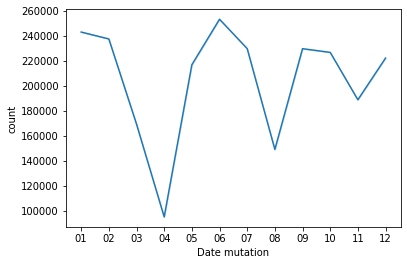

In [70]:
datamois = pd.DataFrame(data,columns=['Date mutation','Nature mutation'])
datamois['Date mutation'] = datamois['Date mutation'].apply(lambda x: x.split(sep='/')[1])
datamois['count'] = datamois.groupby('Date mutation').transform('count')
sns.lineplot(data=datamois, x="Date mutation", y="count")

Nous voyons ici l'impact de la cessation d'activité dûe à la crise du COVID 19 et du premier confinement, survenue à la mi-mars en France.

## Diagramme camembert des nombres de pièces pincipales

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb61fb43d50>],
      dtype=object)

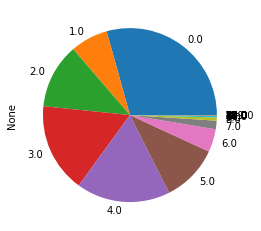

In [71]:
dataIDF = pd.DataFrame(data,columns=['Nombre pieces principales', 'Code departement'])
a = dataIDF.groupby('Nombre pieces principales').size()
a.plot.pie(y = 'Nombres pieces principales', subplots = True)

Nous remarquons ici que le nombre de pièces principales dans chaque demeure est hétérogène, et varie entre 0 et 10.

## Diagramme bâton de la surface de terrain moyen en IDF et dans le reste de la France

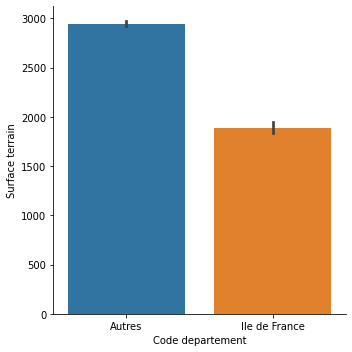

In [72]:
dataIDF = pd.DataFrame(data,columns=['Surface terrain','Code departement'])
dataIDF['Code departement'] = dataIDF['Code departement'].apply(lambda x: 'Ile de France' if(x == '75' or x=='78' or x=='92' or x=='91' or x=='93' or x=='77' or x == '94' or x== '95') else 'Autres')
sns.catplot(x="Code departement", y="Surface terrain", kind='bar', data=dataIDF);

On constate que la surface moyenne hors Ile De France est 1.5 fois supérieure qu'en Ile De France.

## Diagramme bâton de la valeur moyenne Prix/m2 en IDF et dans le reste de la France

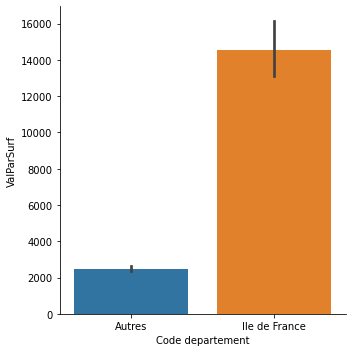

In [73]:
dataIDF = pd.DataFrame(data,columns=['ValParSurf','Code departement'])
dataIDF['Code departement'] = dataIDF['Code departement'].apply(lambda x: 'Ile de France' if(x == '75' or x=='78' or x=='92' or x=='91' or x=='93' or x=='77' or x == '94' or x== '95') else 'Autres')
sns.catplot(x="Code departement", y="ValParSurf", kind='bar', data=dataIDF);

Un m^2 vaut 5,8 fois plus en moyenne en Ile De France (environ 14500€/m^2) que dans le reste dans la France (2500€/m^2). 

## Graphique du prix moyen au m2 des mutations en fonction du temps (mois)

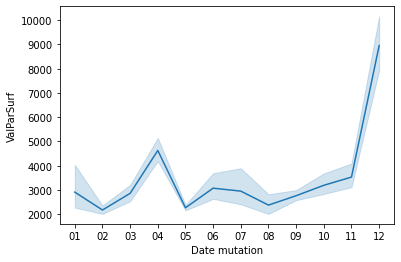

In [75]:
datamois = pd.DataFrame(data,columns=['Date mutation','ValParSurf'])
datamois['Date mutation'] = datamois['Date mutation'].apply(lambda x: x.split(sep='/')[1])
datamois['ValParSurf'] = datamois['ValParSurf'].apply(lambda x: float(x))
datamois.groupby(['Date mutation'])['ValParSurf'].mean()
sns.lineplot(data = datamois, x='Date mutation', y='ValParSurf')

On constate que le prix moyen a été plus élevé vers le mois de mars et avril, et a flambé au cours de la fin de l'année.

## Histogramme des différents types de local

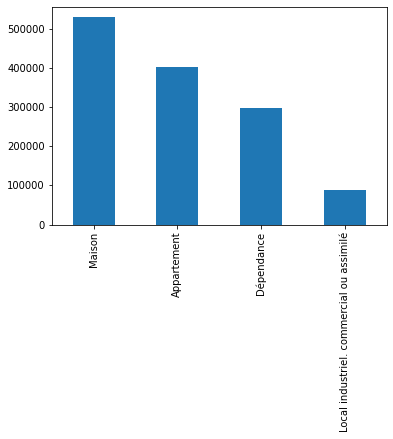

In [76]:
data['Type local'].value_counts().plot(kind='bar')
pp.show()

On constate que la moitié des mutations enregistrées concerne des maisons, suivies ensuite par des appartements et des dépendances.

## Histogramme des différents types de location

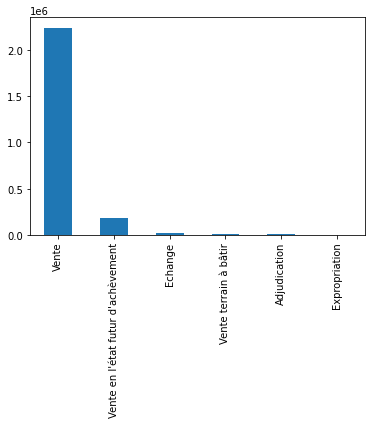

In [77]:
data['Nature mutation'].value_counts().plot(kind='bar')
pp.show()

La vente consisitue la grande majorité des mutations en France.

# Cartes choroplèthes

In [86]:
import plotly

In [87]:
pip install plotly==5.3.1

In [88]:
import pandas as pd
import numpy as np
import json
import plotly.express as px
import math

df=pd.read_csv("valeursfoncieres-2020.txt",sep="|")
def change(x):    #change le format des n° des département ex: 1 => 01          
    y=""          # pour concorder avec le fichier "departements-avec-outre-mer.geojson"
    if str(x).isdigit():
        if int(x)<10:
            y="0{}".format(x)
        else:
            y=str(x)
    else:
        y=str(x)
    return y
df["Code departement"]=df["Code departement"].apply(lambda x: change(x))
df["Valeur fonciere"]=df["Valeur fonciere"].apply(lambda x: float(str(x).replace(",","."))) #valeurs foncieres en float
df['ValParSurf'] = df['Valeur fonciere'].div(df['Surface terrain'])
df.loc[~np.isfinite(df['ValParSurf']), 'ValParSurf'] = np.nan  # change les valeurs "inf" (dû a la division par 0) en NaN

dept_france=json.load(open("departements-avec-outre-mer.geojson","r"))
carte=json.load(open("departements.geojson","r"))  #pour l'affichage des cartes (ne comprend pas les DOM-TOM)
arr_paris=json.load(open("arrondissements.geojson","r"))
dept_id_map={}  #crée un dictionnaire avec les numéros de département en clé et le nom en valeur
for feature in dept_france["features"]:
    feature["id"]=feature["properties"]["nom"]
    dept_id_map[feature["properties"]["code"]]=feature["id"]
for feature in carte["features"]:
    feature["id"]=feature["properties"]["nom"]
arr_id_map={}  #crée un dictionnaire avec les numéros d'arrondissements de paris en clé et le nom en valeur
for feature in arr_paris["features"]:
    feature["id"]=feature["properties"]["l_ar"]
    arr_id_map[feature["properties"]["c_arinsee"]]=feature["id"]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (14,18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.



In [84]:
plotly.__version__

'4.4.1'

In [89]:
df_mean=df.groupby("Code departement",as_index=False).mean() # moyennes des colonnes en fonction des département
df_mean["id"]=df_mean["Code departement"].apply(lambda x: dept_id_map[x] if x not in ['46.0','47.0','nan'] else '46' if x not in ['47.0','nan'] else '47' if x!='nan' else 'nan') # ajoute la colonne id pour faire correspondre df et dept_france

### Carte de la surface du terrain par département

In [90]:
df_mean["Surface terrain log"]=np.log10(df_mean["Surface terrain"])
fig = px.choropleth(df_mean, locations="id", geojson=carte, color="Surface terrain log", scope="europe", 
                    hover_name="id",
                    hover_data=["Surface terrain"])
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

TypeError: ignored

La surface de terrain est plutôt homogène sur toute la France. On peut tout de même remarquer des valeurs très faibles à Paris et en Seine-Saint-Denis, ainsi que des valeurs plus élevées au centre de la France.

### Carte de la valeur fonciere par m² par département

In [ ]:
df_mean["Valeur fonciere/surf log"]=np.log10(df_mean["ValParSurf"])
fig = px.choropleth(df_mean, locations="id", geojson=carte, color="Valeur fonciere/surf log", scope="europe",
                    hover_name="id",                   #nom survol de la carte
                    hover_data=["ValParSurf"])    #ajout de la valeur quand on survole la carte
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

La "diagonale du vide" saute aux yeux sur cette carte en couleur bleue foncée. Les valeurs foncières par m² les plus élévées se trouvent donc dans le sud-est de la France ou en Ile-de-France.

### Carte du nombre de pièces principales par département

In [ ]:
df_mean["Nombre pieces log"]=np.log10(df_mean["Nombre pieces principales"])
fig = px.choropleth(df_mean, locations="id", geojson=carte, color="Nombre pieces log", scope="europe", 
                    hover_name="id",
                    hover_data=["Nombre pieces principales"])
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

Logiquement, on remarque très peu de pièces principales à Paris et en petite couronne, ainsi que dans le sud-est de la France.

### Carte du plus grand nombre de type de local par département

In [ ]:
dfMaxLocal=df.groupby(['Code departement'])['Type local'].apply(lambda x: x.value_counts().index[0]).reset_index()
dfMaxLocal["id"]=dfMaxLocal["Code departement"].apply(lambda x: dept_id_map[x])
fig = px.choropleth(dfMaxLocal, locations="id", geojson=carte, color="Type local", scope="europe", 
                    hover_name="id")    
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

Comme on pouvait s'y attendre, en Ile-de-France, ce sont les appartements qui sont majoritaires. Alors que dans le reste de la France, les maisons sont en plus grand nombre en moyenne.

In [ ]:
df3=df.loc[:, ['Code departement', 'Nature mutation']].groupby('Code departement',as_index=False).count()
df3.columns = ['Code departement', 'Nombre de mutations']

### Carte du nombre de mutations par départements

In [ ]:
df3["id"]=df3["Code departement"].apply(lambda x: dept_id_map[x])
df3["Nombre de mutations log"]=np.log10(df3["Nombre de mutations"])
fig = px.choropleth(df3, locations="id", geojson=carte, color="Nombre de mutations log", scope="europe", 
                    hover_name="id",
                   hover_data=["Nombre de mutations"])    
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

Le nombre de mutations par région le plus faible est en Corse, ce qui n'est pas surprenant. On peut remarquer des valeurs hautes en Gironde ou dans le Nord par exemple.

### Diagramme en bâtons du nombre de mutations par département

In [ ]:
fig = px.bar(df3, 
                 x="Nombre de mutations", y="Code departement", color="Code departement",
                 text="Nombre de mutations", orientation='h', width=800, height=1000,
                 color_discrete_sequence = px.colors.qualitative.Dark2)
fig.show()

On remarque ici directement que la valeur la plus haute du nombre de mutation se situe en Gironde (33) avec 91383, et la plus faible en Haute-Corse (2B) avec 460. On voit aussi grâce à ce diagramme, des valeurs très similaires dans le 91, 92, 93, 94 et 95.

## Arrondissements de Paris

In [ ]:
dfParis=df[(df["Code postal"] > 75000) & (df["Code postal"] < 76000)] #nouveau dataframe composé seulement des DVF situés à Paris
def change1(x):  #change le code postal ex: 75004 => 75104 pour faire comcorder le geojson avec le dataframe
    y=""
    if math.isnan(x)==False:
        if x>75000 and x<76000:
            y=str(int(x)).replace('0', '1',1)
        else:
            y=str(int(x))
    return int(y)
dfParis["Code postal"]=dfParis["Code postal"].apply(lambda x: change1(x))
dfParis["Valeur fonciere"]=dfParis["Valeur fonciere"].apply(lambda x: float(str(x).replace(",","."))) #valeurs foncieres en float
dfParis['ValParSurf'] = dfParis['Valeur fonciere'].div(dfParis['Surface terrain'])
dfParis.loc[~np.isfinite(dfParis['ValParSurf']), 'ValParSurf'] = np.nan  # change les valeurs "inf" (dû a la division par 0) en NaN

In [ ]:
df_mean2=dfParis.groupby("Code postal",as_index=False).mean() # moyennes des colonnes en fonction des département
df_mean2["id"]=df_mean2["Code postal"].apply(lambda x: arr_id_map[x]) # ajoute la colonne id pour faire correspondre df et dept_france

### Carte de la surface du terrain par arrondissement

In [ ]:
df_mean2["Surface terrain log"]=np.log10(df_mean2["Surface terrain"])
fig = px.choropleth(df_mean2, locations="id", geojson=arr_paris, color="Surface terrain log", scope="europe", 
                    hover_name="id",
                    hover_data=["Surface terrain"])
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

En moyenne c'est à l'Est de Paris où les surfaces sont les plus faibles. La surface moyenne la plus haute se trouve dans le 7ème arrondissement, ce qui peut paraître surprenant pour un arrondissement au centre de Paris.

### Carte de la valeur fonciere par m² en fonction des arrondissements

In [ ]:
df_mean2["Valeur fonciere/surf log"]=np.log10(df_mean2["ValParSurf"])
fig = px.choropleth(df_mean2, locations="id", geojson=arr_paris, color="Valeur fonciere/surf log", scope="europe", 
                    hover_name="id",                   #nom survol de la carte
                    hover_data=["ValParSurf"])    #ajout de la valeur quand on survole la carte
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

On constate ici très bien que les valeurs foncières par m² les plus hautes se situent dans le centre de Paris, quartiers les plus aisés. Alors que la valeur la plus basse se trouve dans le 19ème arrondissement, quartier un peu plus défavorisé que les autres.

### Carte du nombre de pièces principales par arrondissement

In [ ]:
df_mean2["Nombre pieces log"]=np.log10(df_mean["Nombre pieces principales"])
fig = px.choropleth(df_mean2, locations="id", geojson=arr_paris, color="Nombre pieces log", scope="europe", 
                    hover_name="id",
                    hover_data=["Nombre pieces principales"])
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

Sur cette carte, deux valeurs nous sautent aux yeux. Le plus faible nombre de pièces principales se trouve dans le 6ème arrondissement, ce qui semble logique puisqu'il s'agit d'un quartier du centre. La plus haute se voit être dans le 16ème arrondissement, ce qui est peut-être dû à sa grande superficie.

### Diagramme en bâtons de la valeur foncière par m² en fonction des arrondissements

In [ ]:
fig = px.bar(df_mean2, 
                 x="ValParSurf", y="id", color="id",
                 text="ValParSurf", orientation='h', width=700,
                 color_discrete_sequence = px.colors.qualitative.Dark2)
fig.show()

On peut voir directement que le 8ème arrondissement possède la plus grande valeur foncière par m² et que le 19ème possède la plus faible. De plus, on peut remarquer que les 13ème, 14ème et 15ème arrondissements ont des valeurs très similaires.

### Digramme en bâtons du nombre de pièces principales par arrondissement

In [ ]:
fig = px.bar(df_mean2, 
                 x="Nombre pieces principales", y="id", color="id",
                 text="Nombre pieces principales", orientation='h', width=700,
                 color_discrete_sequence = px.colors.qualitative.Dark2)
fig.show()

Ce diagramme n'est peut être pas très représentatif car les valeurs sont très proches, mais il permet de réaliser l'importance d'utiliser une échelle logarthmique lors de la représentation des cartes précédentes.

# Comparaison des trois dernières années

In [ ]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import seaborn as sns

data2020 = pd.read_csv("valeursfoncieres-2020.txt",sep= '|',decimal= ',', usecols = ['Date mutation', 'Nature mutation', 'Valeur fonciere', 'Commune', 'Code departement', 'Code commune', 'Surface terrain'])
data2019 = pd.read_csv("valeursfoncieres-2019.txt",sep= '|',decimal= ',', usecols = ['Date mutation', 'Nature mutation', 'Valeur fonciere', 'Commune', 'Code departement', 'Code commune', 'Surface terrain'])
data2018 = pd.read_csv("valeursfoncieres-2018.txt",sep= '|',decimal= ',', usecols = ['Date mutation', 'Nature mutation', 'Valeur fonciere', 'Commune', 'Code departement', 'Code commune', 'Surface terrain'])
data2018['Year'] = int(2018)
data2019['Year'] = int(2019)
data2020['Year'] = int(2020)
all_years = [data2018, data2019, data2020]

data_years = pd.concat(all_years)
data_years['Date mutation'] = data_years['Date mutation'].apply(lambda x: x.split(sep='/')[1] + "/" + x.split(sep='/')[2])
data_years['Prixm2'] = data_years['Valeur fonciere']/data_years['Surface terrain']
def change(x):    #change le format des n° des département ex: 1 => 01          
    y=""          # pour concorder avec le fichier "departements-avec-outre-mer.geojson"
    if str(x).isdigit():
        if int(x)<10:
            y="0{}".format(x)
        else:
            y=str(x)
    else:
        y=str(x)
    return y
data_years["Code departement"]=data_years["Code departement"].apply(lambda x: change(x))
data_years["Valeur fonciere"]=data_years["Valeur fonciere"].apply(lambda x: float(str(x).replace(",","."))) #valeurs foncieres en float
data_years['ValParSurf'] = data_years['Valeur fonciere'].div(data_years['Surface terrain'])
data_years.loc[~np.isfinite(data_years['ValParSurf']), 'ValParSurf'] = np.nan  # change les valeurs "inf" (dû a la division par 0) en NaN

## Comparaison du nombre de ventes ces trois dernières années

In [ ]:
datatry = pd.DataFrame(data_years,columns=['Year','Date mutation'])
datatry['Date mutation'] = datatry['Date mutation'].apply(lambda x: x.split(sep='/')[0])
datatry['count'] = datatry.groupby('Date mutation').transform('count')
datatry['count'] = data_years.groupby(['Year', 'Date mutation']).transform('count')
sns.lineplot(data=datatry, x="Date mutation", y="count", hue="Year")

On constate que les mutations de 2018 et 2019 étaient très homogènes, contrairement à l'année 2020. Cela s'explique par la crise du COVID 19 qui a marqué une baisse d'échange dans tous les secteurs. Cependant, hors la période du premier confinement strict en mars 2020, on voit que les mutations de ces trois dernières années suivent les mêmes tendances en fonction du mois de l'année.

## Graph de comparaison des trois dernières années des prix/m2 par mois

In [ ]:
datamois = pd.DataFrame(data_years,columns=['Date mutation','ValParSurf','Year'])
datamois['Date mutation'] = datamois['Date mutation'].apply(lambda x: x.split(sep='/')[0])
datamois['ValParSurf'] = datamois['ValParSurf'].apply(lambda x: float(x))
datamois.groupby(['Date mutation'])['ValParSurf'].mean()
sns.lineplot(data = datamois, x='Date mutation', y='ValParSurf', hue = 'Year')

On constate que dans l'ensemble, les prix moyens par m^2 de ces trois dernières années ont suivies les mêmes tendances : augmentation au début du printemps et à la fin de l'année.

## Graph des différentes mutations du 1er janvier 2018 au 31 décembre 2020

In [ ]:
datanature = pd.DataFrame(data_years,columns=['Nature mutation','Date mutation'])
datanature['count'] = datanature.groupby('Nature mutation').transform('count')
datanature['count'] = data_years.groupby(['Nature mutation', 'Date mutation']).transform('count')
sns.lineplot(data=datanature, x="Date mutation", y="count", hue = 'Nature mutation')

On voit ici que la nature de mutation la plus impactée par la crise de l'année 2020 comparée aux autres années est la vente. Les autres sont restées périodique à cette période.
De plus, on constate que les ventes et les ventes en l'état futur d'achèvement, les deux principales natures de mutation, suivent les mêmes tendance, dans une moindre mesure pour les ventes en l'état futur d'achèvement qui sont moins nombreuses.

## Histogramme du nombre de mutations des départements de l'Ile de France, comparaison des trois dernières années

In [ ]:
dataIDF = pd.DataFrame(data_years,columns=['Year','Code departement'])
dataIDF['Code departement'] = dataIDF['Code departement'].apply(lambda x: x if(x == '75' or x=='78' or x=='92' or x=='91' or x=='93' or x=='77' or x == '94' or x== '95') else 'NaN')
sns.countplot(x ="Code departement", hue = "Year", data = dataIDF[dataIDF['Code departement'] != 'NaN'])

On voit ici que l'année ayant subies le plus de mutations en Ile De France est l'année 2019. Ces mutations se font essentiellement à Paris, dans le 92 et le 77.
Cependant, nous remarquons également que le département le plus touché par l'épidémie de 2020 est le 92. Ses mutations ont diminué de 1.8 fois entre 2019 et 2020.

## Histogramme du nombre de type par mutation, comparé par années

In [ ]:
sns.countplot(x ="Nature mutation", hue = "Year", data = data_years)

Nous constatons ici que toutes années confondues, la Vente est de loin la nature de mutation la plus répendue. Aussi, nous constons que les ventes ont diminué de 1.5 fois entre 2019 et 2020.